# Biomarker Identification - Mirdametinib

In [1]:
import os

cwd = os.getcwd()
DATA = cwd + '/data'

## Association between MAP2K1/2 mutation and MEK inhibitor

This analysis follows the steps in the [Barretina et al.](https://www.nature.com/articles/nature11003) paper to investigate Mirdametinib, a MEK inhibitor. 

The Cancer Dependency Map (DepMap) project is an umbrella project that aims to providing high quality genomic profilings of cancer cell lines (CCLE), their sensitivities to genetic perturbations (Achilies, DRIVE, DEMETER2, etc.), and their sensitivities to small molecule perturbations (PRISM). Mining these data allows us to better understand cancer biology, and potentially discover new genes for targeted therapies.


The first dataset that I will be using is the drug response data from PRISM, which stands for Profiling Relative Inhibition Simultaneously in Mixtures and is a project within DepMap. It uses high-throughput multiplexed screening on hundreds of human cancer cell lines and allows researchers to validate the mechanisms of action (MoA) of drugs, or identify potential novel targets of existing drugs for drug repurposing.

At the time when this dataset was published, Mirdametinib was called by its lab name `PD-0325901`. The drug response data can be loaded and only the rows having `name=='PD-0325901'` will be included. Only those rows with `passed_str_profiling==True` have been kept.

In [5]:
import pandas as pd

prism = pd.read_csv(DATA + "/secondary-screen-dose-response-curve-parameters.csv")
prism = prism[prism.passed_str_profiling==True]
prism = prism[prism.name=="PD-0325901"]
print(prism.shape)
prism.head()

/Users/crystalshin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(462, 20)


,broad_id,depmap_id,ccle_name,screen_id,upper_limit,lower_limit,slope,r2,auc,ec50,ic50,name,moa,target,disease.area,indication,smiles,phase,passed_str_profiling,row_name
320706,BRD-K49865102-001-08-4,ACH-000879,MFE296_ENDOMETRIUM,HTS002,1,1.753852,-0.140424,0.049046,1.358403,0.037749,NaN,PD-0325901,MEK inhibitor,MAP2K1,NaN,NaN,OC[C@@H](O)CONC(=O)c1ccc(F)c(F)c1Nc1ccc(I)cc1F,Phase 2,True,ACH-000879
320707,BRD-K49865102-001-08-4,ACH-000320,PSN1_PANCREAS,HTS002,1,0.017189,0.867499,0.768102,0.309807,0.009980,0.010391,PD-0325901,MEK inhibitor,MAP2K1,NaN,NaN,OC[C@@H](O)CONC(=O)c1ccc(F)c(F)c1Nc1ccc(I)cc1F,Phase 2,True,ACH-000320
320708,BRD-K49865102-001-08-4,ACH-001145,OC316_OVARY,HTS002,1,0.240523,1.622713,0.687787,0.578996,0.046090,0.069049,PD-0325901,MEK inhibitor,MAP2K1,NaN,NaN,OC[C@@H](O)CONC(=O)c1ccc(F)c(F)c1Nc1ccc(I)cc1F,Phase 2,True,ACH-001145
320709,BRD-K49865102-001-08-4,ACH-000873,KYSE270_OESOPHAGUS,HTS002,1,0.387321,3.827219,0.586254,0.734215,0.148506,0.219195,PD-0325901,MEK inhibitor,MAP2K1,NaN,NaN,OC[C@@H](O)CONC(=O)c1ccc(F)c(F)c1Nc1ccc(I)cc1F,Phase 2,True,ACH-000873
320710,BRD-K49865102-001-08-4,ACH-000855,KYSE150_OESOPHAGUS,HTS002,1,0.350424,0.754771,0.680582,0.722535,0.164757,0.815145,PD-0325901,MEK inhibitor,MAP2K1,NaN,NaN,OC[C@@H](O)CONC(=O)c1ccc(F)c(F)c1Nc1ccc(I)cc1F,Phase 2,True,ACH-000855


In this dataset, each row is a cell line-drug pair, where `depmap_id` column indicates the cell line ID as in the cell line info table above. The compound (drug) name can be found in the `name` column. If the molecule is designed to target a certain gene, it will be annotated in the `target` and `moa` columns. This allows us to investigate how inhibition of a certain pathway affect the viability of cancer cell lines with a certain mutation profiles.

As we can see in the above table, we have selected out 462 cell lines that have sensitivity data for `PD-0325901`.

## Association between MEK1/2 mutation and PD-0325901

Now that we have identified which cell lines have sensitivity data for `PD-0325901`, we can now study the correlation between `PD-0325901` and its target genes `MEK1 (MAP2K1)` and `MEK2 (MAP2K2)`. The goal is to find in which specific genomic feature such as mutations, copy number variation, or over/under expression the drug will have the highest potency. 

We can load in the CCLE mutation MAF file for this analysis. Each cancer cell line is derived from a tumor, and knowing the information from the source of the cell line oftentimes could help the drug developers identify the indications ofinterest by answering questions like: in which cancer types are BRCA1/BRCA2 mutations most prevalent? 

When we load in the mutation dataset, we will make sure that we load in the rows that meet certain conditions. First, the `isDeleterious` column indicates if the mutation is deleterious. The `Variant_annotation` column indicates whether the mutation is damaging. The `isCOSMIChotspot` column shows whether the mutation has been observed as a mutation hotspot in the COSMIC (Catalogue of Somatic Mutations in Cancer) database. The union of the three columns would be used to filter out those mutations that are potentially associated with damaging the target genes. 

In [8]:
maf = pd.read_csv(DATA + "/CCLE_mutations.csv")
maf.head()

/Users/crystalshin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (3,19,22,27,28,29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,Variant_annotation,CGA_WES_AC,HC_AC,RD_AC,RNAseq_AC,SangerWES_AC,WGS_AC
0,VPS13D,55187,37,1,12359347,12359347,+,Nonsense_Mutation,SNP,C,...,False,0.0,NaN,damaging,34:213,NaN,NaN,NaN,34:221,NaN
1,AADACL4,343066,37,1,12726308,12726322,+,In_Frame_Del,DEL,CTGGCGTGACGCCAT,...,False,3.0,NaN,other non-conserving,57:141,NaN,NaN,NaN,9:0,28:32
2,IFNLR1,163702,37,1,24484172,24484172,+,Silent,SNP,G,...,False,0.0,NaN,silent,118:0,NaN,NaN,10:0,118:0,18:0
3,TMEM57,55219,37,1,25785018,25785019,+,Frame_Shift_Ins,INS,-,...,False,0.0,NaN,damaging,NaN,NaN,NaN,6:28,NaN,NaN
4,ZSCAN20,7579,37,1,33954141,33954141,+,Missense_Mutation,SNP,T,...,False,0.0,NaN,other non-conserving,28:62,NaN,NaN,NaN,27:61,NaN


In [13]:
mek = maf[((maf.Hugo_Symbol == "MAP2K1") | (maf.Hugo_Symbol == "MAP2K2"))&
           (maf.isDeleterious | (maf.Variant_annotation == "damaging") | maf.isCOSMIChotspot)]
mek

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,Variant_annotation,CGA_WES_AC,HC_AC,RD_AC,RNAseq_AC,SangerWES_AC,WGS_AC
179706,MAP2K2,5605,37,19,4110508,4110508,+,Splice_Site,SNP,A,...,False,0.0,NaN,damaging,43:115,98:184,NaN,220:331,14:26,NaN
274669,MAP2K1,5604,37,15,66777530,66777530,+,Splice_Site,SNP,G,...,False,0.0,NaN,damaging,26:11,42:35,NaN,5:0,NaN,NaN
750333,MAP2K1,5604,37,15,66779629,66779629,+,Splice_Site,SNP,A,...,False,0.0,NaN,damaging,25:45,115:136,NaN,NaN,NaN,NaN
758884,MAP2K1,5604,37,15,66737045,66737045,+,Splice_Site,SNP,G,...,False,0.0,NaN,damaging,53:30,29:16,NaN,185:149,NaN,NaN
814497,MAP2K1,5604,37,15,66737045,66737045,+,Splice_Site,SNP,G,...,False,0.0,NaN,damaging,63:86,63:59,NaN,331:417,67:84,NaN
966081,MAP2K1,5604,37,15,66782055,66782055,+,Splice_Site,SNP,G,...,False,0.0,NaN,damaging,127:490,NaN,NaN,NaN,NaN,NaN


We were able to identify 6 cell lines that are either deliterious, damaging or appear in COSMIC hotspot database. 

Now we can use the PRISM data to extract the drug screening result. To do this, we would select for all rows that have `depmap_id` appear in the mutation data's `DepMap_ID`. Then we would extract the columns `auc` (auc, which is the inverse of activity area), `ec50`, and `ic50`. Also, we would add a column indicating whether there is a mutation in MEK genes for each cell line. 

In [16]:
plotdata = prism[
    (prism.passed_str_profiling) & 
    (prism.name == "PD-0325901") & 
    prism.depmap_id.isin(set(maf.DepMap_ID))
][
    ["depmap_id", "auc", "ec50", "ic50",]
].copy()

plotdata["MEK_mut"] = False
plotdata.loc[plotdata.depmap_id.isin(set(mek.DepMap_ID)), "MEK_mut"] = True
plotdata.head()

,depmap_id,auc,ec50,ic50,MEK_mut
320706,ACH-000879,1.358403,0.037749,NaN,False
320707,ACH-000320,0.309807,0.009980,0.010391,False
320708,ACH-001145,0.578996,0.046090,0.069049,False
320709,ACH-000873,0.734215,0.148506,0.219195,False
320710,ACH-000855,0.722535,0.164757,0.815145,False


Using the table created, we can create a boxplot showing the area under the curve between the cell lines that have at least one damaging mutation in `MAP2K1` or `MAP2K2` gene. We can also perform a 2-sided Mann-Whitney U test to see if the difference is statistically significant.

/Users/crystalshin/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(1, 1.6, 'M-W U P-value = 0.7351')

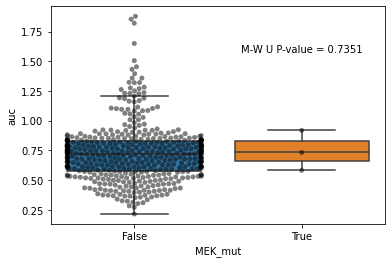

In [17]:
from scipy.stats import mannwhitneyu
import seaborn as sns
import numpy as np

mwu, pval = mannwhitneyu(plotdata.loc[plotdata.MEK_mut, "auc"],
                         plotdata.loc[~plotdata.MEK_mut, "auc"], alternative="two-sided")
ax = sns.boxplot(x="MEK_mut", y="auc", data=plotdata, fliersize=0)
ax = sns.swarmplot(x="MEK_mut", y="auc", data=plotdata, color="k",
                  alpha=0.5, ax=ax)

ax.text(1, 1.6, "M-W U P-value = {}".format(np.round(pval, 4)), ha="center", va="center")

In [22]:
plotdata.MEK_mut.sum()

3

From the boxplot, we do not see much difference between the two groups and the p-value was 0.74, supporting that it is not statistically significant. Also, there are only 3 cell lines that have mutations in MEK genes.

## Identifying Other Predictive Features for Mirdametinib

Since mutation in MEK genes were not highly associated with Mirdametinib, we could try to identify other predictive features. Here, we will only investigate mutation features' association with the response. We will create a `feat` matrix with pivoted mutation data, subset the feature matrix to only the cell lines that has auc values from `PD-0325901`, then fit it to the `SelectFromModel` feature selector with `RandomForestRegressor` estimator.

In [23]:
maf_nn = maf[(maf.isDeleterious | (maf.Variant_annotation == "damaging") | maf.isCOSMIChotspot.astype(bool))]
mut_mat = maf_nn.pivot_table(
    index="Hugo_Symbol", columns="DepMap_ID", values="Start_position",
    # the values can be anything, as we just want to convert it to number of mutations
    aggfunc=len, fill_value=0
)
mut_mat.index = mut_mat.index.to_series() + "_mut"
feat = mut_mat.T
feat

Hugo_Symbol,A1BG_mut,A1CF_mut,A2M_mut,A2ML1_mut,A3GALT2_mut,A4GALT_mut,A4GNT_mut,AAAS_mut,AACS_mut,AADAC_mut,...,ZWINT_mut,ZXDA_mut,ZXDB_mut,ZXDC_mut,ZYG11A_mut,ZYG11B_mut,ZYX_mut,ZZEF1_mut,ZZZ3_mut,hsa-mir-1199_mut
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000001,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
ACH-000002,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ACH-000003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACH-000004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACH-000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACH-002509,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACH-002510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Like we did previously, we can extract just the cell lines from the `feat` matrix.

In [25]:
target = prism.loc[
    (prism.passed_str_profiling) & 
    (prism.name == "PD-0325901"),
    ["auc", "depmap_id"]
].set_index("depmap_id", drop=True)
target

,auc
depmap_id,
ACH-000879,1.358403
ACH-000320,0.309807
ACH-001145,0.578996
ACH-000873,0.734215
ACH-000855,0.722535
...,...
ACH-000977,0.835512
ACH-000397,1.103102
ACH-000565,0.409922


In [26]:
# find common samples
common_celllines = list(set(target.index) & set(feat.index))
target = target.loc[common_celllines]
feat = feat.loc[common_celllines]
print(feat.shape)
np.all(feat.index == target.index)

(462, 18135)


True

Using the `RandomForestRegressor`, we can fit a model to select the feature with the highest importance. The target variable for the model to learn is the `auc`. 

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

feat_sel = SelectFromModel(
    RandomForestRegressor(random_state=4060)
).fit(feat, target)

/Users/crystalshin/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:224: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


Within the feature selector, there is an `estimator_` attribute that contains the fitted random forest model. The `feature_importance_` attribute contains information about the importance of each feature in the model. We can create a new table listing features by its importance

In [28]:
feature_importance = pd.DataFrame({
    "feature": feat.columns,
    "importance": feat_sel.estimator_.feature_importances_
}).sort_values("importance", ascending=False)
feature_importance

,feature,importance
1617,BRAF_mut,0.057794
8153,KRAS_mut,0.043856
4224,DET1_mut,0.021713
4515,DPY19L1_mut,0.021441
10365,NRAS_mut,0.019281
...,...,...
7742,KBTBD3_mut,0.000000
7743,KBTBD4_mut,0.000000
7744,KBTBD6_mut,0.000000
7745,KBTBD7_mut,0.000000


In this case, the top predictive mutation feature was the BRAF mutation. BRAF gene works together with MEK gene to provide instructions for producing MEK1, which is a protein kinase that controls proper cell growth and division. Thus it makes sense that this gene might be of interest to us.